### average HVSR ratio over events


In [2]:
# load modulus
import numpy as np
# import seissolxdmf
import pandas as pd
# import scipy.spatial as spatial
import matplotlib.pyplot as plt

from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

In [3]:
import matplotlib
from matplotlib.ticker import MultipleLocator
print(matplotlib.style.available)

# matplotlib.rc('font', **font)
matplotlib.style.use('seaborn-v0_8-paper') # Lovely plotting style

# define working rootfolder : NSHM
rootfolder = '/Users/DuoL/Documents/NSHM/'

siteTable = pd.read_csv(rootfolder + 'Model_kinematic/site_subtable2.csv')
print(siteTable.keys())
print(siteTable.sta[0])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Index(['Unnamed: 0', 'net', 'sta', 'lat', 'lon', 'elev', 'site_class', 'Vs30',
       'Vs30_std', 'Q_Vs30', 'Vs30_Ref', 'T0', 'T0_std', 'Q_T0', 'D_T0',
       'T0_ref', 'Z1.0', 'Z1.0_std', 'Q_Z1.0', 'Z1.0_ref', 'Z2.5', 'Z2.5_std',
       'Q_Z2.5', 'Z2.5_ref', 'site_domain_no', 'basin'],
      dtype='object')
ARKS


In [4]:
# import instaseis and dependency
from obspy import read
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max
from obspy import UTCDateTime

from obspy import read,read_inventory
from obspy import Trace, Stream
from obspy.geodetics import gps2dist_azimuth

In [5]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2

In [14]:

import os.path
from scipy.fft import fft, fftfreq

ch = ['BNE','BNN','BNZ']

SAMPLE_RATE = 1/0.005 # data sample rate in SeisSol

rootfolder = '/Users/DuoL/Documents/NSHM/Central/'
folder  = rootfolder + './F3/s15r45/'
modelname = 'jp3zBa'

folder = rootfolder + 'Joint3/data-jp3zBc-rec/'

st_syn = Stream()

for ista in range(1,72):

    if ista < 10 :
        filename = folder + modelname + '-receiver-0000' + str(ista) + '-00000.dat'
    else:
        filename = folder + modelname + '-receiver-000' + str(ista) + '-00000.dat'

    if os.path.isfile(filename):
    
        t, vx, vy, vz= np.loadtxt(filename, comments='#', skiprows=2, usecols=(0,7,8,9),unpack=True)

        st = Stream([Trace(vx),Trace(vy),Trace(vz)])    
    
        for tr_num in range(3):
            st[tr_num].stats['sampling_rate'] = SAMPLE_RATE
            st[tr_num].stats['network'] = 'SeisSol'
            st[tr_num].stats['station'] = str(ista)
            st[tr_num].stats['channel'] = ch[tr_num]
        st_syn += st


    else:
        pass


## calculate from Vel to ACC
f1 = 0.01
f2 = 2.0 

st_syn1 = st_syn.copy()
# st_syn1.differentiate()

st_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

print('3C acc:',st_syn1)
st_syn1.write(rootfolder + './Joint3/syn/vel-' + modelname + '.mseed',format='mseed')

# st_syn1 = read(rootfolder + './F3/data/vel-' + modelname + '-1hz.mseed',format='mseed')

print(st_syn1)

3C acc: 198 Trace(s) in Stream:

SeisSol.1..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:19.995000Z | 200.0 Hz, 16000 samples
...
(196 other traces)
...
SeisSol.71..BNZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:19.995000Z | 200.0 Hz, 16000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
198 Trace(s) in Stream:

SeisSol.1..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:19.995000Z | 200.0 Hz, 16000 samples
...
(196 other traces)
...
SeisSol.71..BNZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:19.995000Z | 200.0 Hz, 16000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [8]:
def sdof_response(dat, dtsamp, fosc, dampfac=0.05):
    '''This gives c

    Parameters
    --------------------
    dat: array like
    the input acceleration data without the time samples
    dtsamp: float
    the sampling interval of the time series.
    fosc: float
    The natural frequency of the SDOF oscillator at which the response is desired.
    dampfac: float
    damping of the SDOF oscillator, its optional default is the usual 0.05.

    Returns
    ----------------------
    sa: float
    the absolute spectral amplitude or the maximum of the response motion
    times: array
    the time samples for the response motion same as for the input motion
    resp : array
    the full response motion of acceleration
    '''
    # See the mathematica version in Response Spectrum and for algorithm see the book in German.
    omegaosc = 2 * np.pi * fosc
    lamda = -dampfac * omegaosc + 1j * omegaosc * np.sqrt(1 - dampfac ** 2)
    c1 = np.exp(lamda * dtsamp)
    c2 = 2 * (1 - c1) / ((lamda - np.conj(lamda)) * dtsamp)
    y0 = 2 * lamda * (-dat[0]) / (lamda - np.conj(lamda))
    deltaai = dat[1:] - dat[:-1]     # the linear approximation of acceleration between adjacent samples.
    yi = y0
    resp = np.empty(len(dat))
    resp[0] = np.real(yi)
    for i, deltaa in enumerate(deltaai, 1):
        yi = c1 * yi + c2 * deltaa
        resp[i] = np.real(yi)        # first resp is relative motion
    resp = resp + dat                # Finally I compute total absolute movement by adding resp with input acceleration
    sa = max(np.abs(resp))
    times = np.arange(0, len(dat) * dtsamp, dtsamp, dtype=float)
    return sa, times, resp

In [9]:
# code from Sanjay; uniformly process data

from obspy.signal.invsim import cosine_taper 
from scipy import fftpack
def fourierspec_cal(data, dtsamp):
    ''' Gives the Fourier amplitude spectrum of a input signal.
    Parameters
    -----------------------
    data: array like
        input time signal
    dtsamp :
        sampling interval

    Returns
    freqlist: array like
        The positive signal frequencies
    fas : array like
        Positive frequency side FAS.'''
    n = len(data)
    taper = cosine_taper(n)
    sign_tap = taper*data # Tapered signal
    fft = dtsamp*fftpack.fft(sign_tap) # See the documentation of scipy.fftpack
    # Multiplication with sampling period makes it equivalent to continous Fourier transform. See Mathematica code of
    # Frank Scherbaum and fourierspec_Cal.
    freqlist = fftpack.fftfreq(n, dtsamp)
    freqs_mask = (freqlist >= 0)
    freqlist = freqlist[freqs_mask]
    fas = np.abs(fft)
    fas = fas[freqs_mask]
    return freqlist, fas

IndexError: list index out of range

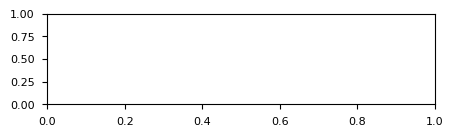

In [38]:
## loop over evelist 

# print(evelat,evelon,eventname)

for ista in range(1,61):

    sta = str(ista)
    # t_init1 = st_data1[0].stats.starttime ## trim to the same length
    # t_init2 = st_syn1[0].stats.starttime

    # st_data1.trim(t_init1, t_init1+25)
    # st_syn1.trim(t_init2, t_init2+25)

    # sta_lat = siteTable[siteTable['sta']==sta].lat.to_numpy()
    # sta_lon = siteTable[siteTable['sta']==sta].lon.to_numpy()
    
    # print(evelat[id],evelon[id])
    # coordinatesistance, azimuth, backazimuth = gps2dist_azimuth(evelat[id],evelon[id],sta_lat,sta_lon)
    # print(sta, coordinatesistance/1e3, azimuth, backazimuth)

    # normalized by the max amplitude in synthtic.

    # print(sta, shift, np.round(value,3))   

    shift = 0
    
    plt.figure(figsize=(5, 4))

    ax1 = plt.subplot(311)

    ax1.plot(st_syn1.select(station=sta,channel='BNZ')[0].times(),np.roll(st_syn1.select(station=sta,channel='BNZ')[0].data,shift),'k',label='Z' )
    # ax1.text(1,0.6,str(np.round(value,3)),fontsize=12)
    ax1.legend(loc='upper right')
    ax1.set_title(siteTable.sta[ista])

    ax3 = plt.subplot(313,sharey=ax1)
    ax3.plot(st_syn1.select(station=sta,channel='BNN')[0].times(),np.roll(st_syn1.select(station=sta,channel='BNN')[0].data,shift),'tomato',label='N' )
    ax3.legend(loc='upper right')
    
    
    ax2 = plt.subplot(312,sharey=ax1)
    ax2.plot(st_syn1.select(station=sta,channel='BNE')[0].times(), np.roll(st_syn1.select(station=sta,channel='BNE')[0].data,shift),'royalblue',label='E' )
    ax2.legend(loc='upper right')
    
    # ax3.set_title('0.01~1.0 Hz')
    # ax2.set_title('Dist:'+ str(np.round(coordinatesistance/1e3,1)) + ',BAZ:' + str(np.round(backazimuth,1)) )
    # ax3.set_ylim([-2.0, 2.0])

    ax3.set_xlim([0, 80])
    ax3.set_xscale('linear')
    ax3.set_yscale('linear')

    ax3.set_xticks([0,10,20,30,40,50,60,70,80])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])

    outfolder = rootfolder + 'Joint3/figures-jp3zBc/'  # + 'figures-jp3xSF2/'
    fftname = outfolder + '/' +  'Vel-' + str(siteTable.sta[ista]) + '.png'  # index change

    plt.savefig(fftname,dpi=300, transparent=True)
    # plt.show()
    plt.close()


In [ ]:
# H/V Fourier spectral ratio
## 
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing
from SpecFunc.fourierspec_call import *

for ista in range(1,30):

    try:
        sta = str(ista)

        freqlist_syn, fas_syn = fourierspec_cal(st_syn1.select(station=sta,channel='BNZ')[0].data, st_syn1.select(station=sta)[0].stats['delta'])
        freqlist_syn, fas_syn1 = fourierspec_cal(st_syn1.select(station=sta,channel='BNE')[0].data, st_syn1.select(station=sta)[0].stats['delta'])
        freqlist_syn, fas_syn2 = fourierspec_cal(st_syn1.select(station=sta,channel='BNN')[0].data, st_syn1.select(station=sta)[0].stats['delta'])

        # fas_synSA = konno_ohmachi_smoothing(fas_syn, freqlist_syn,bandwidth=60,normalize=True)
        # fas_synSA1 = konno_ohmachi_smoothing(fas_syn1, freqlist_syn,bandwidth=60,normalize=True)
        # fas_synSA2 = konno_ohmachi_smoothing(fas_syn2, freqlist_syn,bandwidth=60,normalize=True)

        # r_syn = np.sqrt(0.5*(fas_synSA1**2 + fas_synSA2**2))/fas_synSA
        
        fig,ax3 = plt.subplots(1,1,figsize=(4,3))
        
        plt.figure(figsize=(5, 3))

        ax3 = plt.subplot(111)
        
        ax3.plot(freqlist_syn, fas_syn ,'black',label=str(siteTable.sta[ista])+':Z')
        ax3.plot(freqlist_syn, fas_syn1 ,'tomato',label='E')
        ax3.plot(freqlist_syn, fas_syn2 ,'royalblue',label='N')

        ax3.legend()
        
        ax3.set(ylim=(0.0001,10))
        ax3.set_xlabel('frequency (hz)')
        ax3.set_ylabel('FAS (m/s)')
        ax3.set(xlim=(0.01,5.0))
        ax3.set_xscale('log',base=10)
        ax3.set_yscale('log',base=10)
        ax3.grid(linestyle=':',which ='both')
        
        fftname = outfolder + '/'  + 'FAS-'+ str(siteTable.sta[ista]) + '.png'  # index change

        plt.savefig(fftname,dpi=300, transparent=False)
        # plt.show()
        plt.close()
    except:
        pass



In [583]:

plt.figure(figsize=(6, 3))
ax3 = plt.subplot(111)


for ieve in range(inum*3):
    ax3.plot(freq1,gof[:,ieve],'skyblue',alpha=0.15)

ax3.set_title('sta:'+ sta)

ax3.set(ylim=(-10,10))
ax3.set_xlabel('freq (hz)')
ax3.set_ylabel(r"log($\frac{FAS_{data}}{FAS_{model}}$)")
ax3.set(xlim=(0.1,2.0))
ax3.set_xticks([0.5,1,1.5,2])
ax3.grid(linestyle=':',which ='major')

Y1min = np.std(gof, axis=1)

ax3.fill_between(freq1, np.mean(gof,axis=1)+Y1min, np.mean(gof,axis=1)-Y1min, color="royalblue", alpha=0.3)
ax3.plot(freq1, np.mean(gof,axis=1),'royalblue',label='mean')
ax3.legend()

plt.savefig(fftname,dpi=300, transparent=False)
plt.close()

In [364]:
np.log10(2)

0.3010299956639812

In [554]:
t_init = st_syn1[0].stats.starttime

1970-01-01T00:00:00.000000Z

In [631]:
15.2*59/2

448.4